## TASK B FLAG ANALYSIS

In [ ]:




# 5. Regional analysis
# Let's extract region from country names (simplified)
def extract_region(country):
    european_countries = ['france', 'germany', 'italy', 'spain', 'uk', 'switzerland', 'netherlands', 
                         'sweden', 'norway', 'finland', 'denmark', 'belgium', 'austria', 'poland',
                         'portugal', 'greece', 'ireland', 'luxembourg', 'czechia', 'slovakia', 'hungary',
                         'slovenia', 'croatia', 'romania', 'bulgaria', 'estonia', 'latvia', 'lithuania',
                         'malta', 'cyprus', 'iceland', 'liechtenstein', 'monaco', 'andorra', 'sanmarino',
                         'vatican', 'albania', 'serbia', 'montenegro', 'macedonia', 'bosnia']
    
    african_countries = ['egypt', 'southafrica', 'nigeria', 'kenya', 'morocco', 'algeria', 'tunisia',
                        'ghana', 'ethiopia', 'uganda', 'tanzania', 'rwanda', 'sudan', 'southsudan',
                        'senegal', 'ivorycoast', 'mali', 'cameroon', 'congo', 'drcongo', 'zambia',
                        'zimbabwe', 'namibia', 'botswana', 'madagascar', 'mozambique', 'angola',
                        'libya', 'gabon', 'guinea', 'benin', 'togo', 'sierraleone', 'liberia',
                        'burundi', 'lesotho', 'swaziland', 'eritrea', 'niger', 'chad', 'mauritania',
                        'somalia', 'djibouti', 'gambia', 'malawi']
    
    asian_countries = ['china', 'japan', 'india', 'southkorea', 'northkorea', 'vietnam', 'thailand',
                      'indonesia', 'malaysia', 'singapore', 'philippines', 'myanmar', 'cambodia',
                      'laos', 'mongolia', 'nepal', 'bhutan', 'srilanka', 'bangladesh', 'pakistan',
                      'afghanistan', 'iran', 'iraq', 'syria', 'jordan', 'lebanon', 'israel',
                      'palestine', 'saudiarabia', 'uae',


hello


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib.patches import Rectangle

In [2]:
FLAGS_DIR='./Flag_Analysis/country-flags-main/png1000px'

In [3]:
def get_flag_files():
    flag_files = []
    for file in os.listdir(FLAGS_DIR):
        if file.endswith('.png'):
            country = file.split('.')[0]
            flag_files.append((country, file))
    return flag_files

# 1. Load and analyze flag images
flag_files = get_flag_files()
print(f"Found {len(flag_files)} flag images")

Found 255 flag images


In [4]:
for i, (country, file) in enumerate(flag_files[:5]):
    print(f"{i+1}. {country}: {file}")

1. Afghanistan: Afghanistan.png
2. Aland Islands: Aland Islands.png
3. Albania: Albania.png
4. Algeria: Algeria.png
5. American Samoa: American Samoa.png


### ASPECT RATIO AND NO OF VISUAL DIVISIONS ANALYSIS

In [11]:
def analyze_flag(image_path):
    # Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get dimensions
    height, width, _ = img.shape
    aspect_ratio = width / height
    
    # Extract dominant colors using K-means clustering
    pixels = img_rgb.reshape(-1, 3)
    n_colors = 8
    kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(pixels)
    counts = Counter(kmeans.labels_)
    
    # Get proportions of each color cluster
    color_proportions = {}
    centers = kmeans.cluster_centers_
    for i in range(n_colors):
        proportion = counts[i] / len(pixels)
        # Skip very small proportions (likely noise)
        if proportion > 0.03:  
            color = tuple(map(int, centers[i]))
            color_proportions[color] = proportion
    
    # Dominant color count (excludes very small proportions)
    dominant_color_count = len(color_proportions)
    
    # Calculate the number of horizontal, vertical, or diagonal divisions
    
    horizontal_divisions = 0
    vertical_divisions = 0
    diagonal_divisions = 0
    
    # Check for horizontal divisions by examining rows
    row_colors = []
    for y in range(0, height, height//10):  # Sample 10 rows
        row = img_rgb[y, width//2]
        row_colors.append(tuple(row))
    unique_row_colors = len(set(tuple(map(tuple, row_colors))))
    if unique_row_colors > 1:
        horizontal_divisions = unique_row_colors - 1
    
    # Check for vertical divisions by examining columns
    col_colors = []
    for x in range(0, width, width//10):  # Sample 10 columns
        col = img_rgb[height//2, x]
        col_colors.append(tuple(col))
    unique_col_colors = len(set(tuple(map(tuple, col_colors))))
    if unique_col_colors > 1:
        vertical_divisions = unique_col_colors-1
    
    # Check for diagonal patterns (simplified check)
    diag_colors = []
    for i in range(10):
        y = (height * i) // 10
        x = (width * i) // 10
        if y < height and x < width:
            diag_colors.append(tuple(img_rgb[y, x]))
    unique_diag_colors = len(set(tuple(map(tuple, diag_colors))))
    if unique_diag_colors > 1:
        diagonal_divisions = unique_diag_colors - 1
    
    # Check for symbols
    # Convert to grayscale and apply edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # If we have many contours relative to the image size, likely has symbols
    contour_density = len(contours) / (width * height) * 10000
    has_symbol = contour_density > 0.5  # Threshold can be adjusted
    
    return {
        'aspect_ratio': aspect_ratio,
        'dominant_color_count': dominant_color_count,
        'color_proportions': color_proportions,
        'horizontal_division': horizontal_divisions,
        'vertical_division': vertical_divisions,
        'diagonal_division': diagonal_divisions,
        'has_symbol': has_symbol,
        'contour_density': contour_density
    }


In [13]:
# Analyze all flags and store results
flag_data = []

for country, file in flag_files:
    try:
        image_path = os.path.join(FLAGS_DIR, file)
        analysis = analyze_flag(image_path)
        
        # Add country info to analysis results
        analysis['country'] = country
        analysis['file'] = file
        
        # Extract main colors for simplified analysis
        analysis['colors'] = list(analysis['color_proportions'].keys())
        
        flag_data.append(analysis)
        
        if len(flag_data) % 10 == 0:
            print(f"Processed {len(flag_data)} flags...")
            
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Create a DataFrame from the collected data
df = pd.DataFrame(flag_data)

# Remove the color_proportions column (complex nested structure)
df = df.drop('color_proportions', axis=1)

Processed 10 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 20 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 30 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 40 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 50 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 60 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 70 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 80 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 90 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 100 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 110 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 120 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 130 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 140 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 150 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 160 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 170 flags...
Processed 180 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Error processing Republic of TÃ¼rkiye.png: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Error processing RÃ©union.png: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Error processing Saint BarthÃ©lemy.png: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Processed 190 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 200 flags...
Processed 210 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 220 flags...
Processed 230 flags...


c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processed 240 flags...
Processed 250 flags...


In [14]:
print(df[['country', 'aspect_ratio', 'dominant_color_count', 
          'horizontal_division', 'vertical_division', 
          'diagonal_division', 'has_symbol']].head())

          country  aspect_ratio  dominant_color_count  horizontal_division  \
0     Afghanistan      1.499250                     4                    1   
1   Aland Islands      1.529052                     3                    2   
2         Albania      1.400560                     2                    1   
3         Algeria      1.499250                     3                    1   
4  American Samoa      2.000000                     3                    2   

   vertical_division  diagonal_division  has_symbol  
0                  4                  4        True  
1                  0                  2       False  
2                  1                  1       False  
3                  3                  3       False  
4                  3                  2        True  


### ASPECT RATIO ANALYSIS

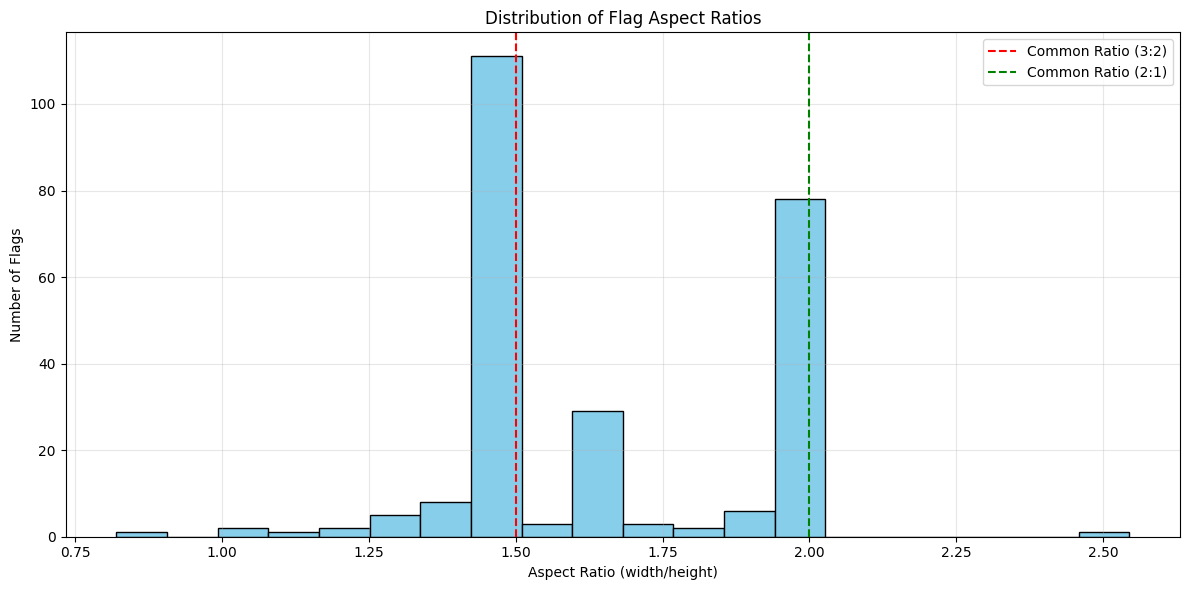

Most common aspect ratios:
aspect_ratio_rounded
1.5    110
2.0     78
1.7     23
1.4     10
1.6      9
1.9      6
1.3      5
1.8      4
1.2      3
1.0      2
Name: count, dtype: int64


In [18]:
# 2. Analyze aspect ratios
plt.figure(figsize=(12, 6))
plt.hist(df['aspect_ratio'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Flag Aspect Ratios')
plt.xlabel('Aspect Ratio (width/height)')
plt.ylabel('Number of Flags')
plt.grid(alpha=0.3)
plt.axvline(x=1.5, color='red', linestyle='--', label='Common Ratio (3:2)')
plt.axvline(x=2.0, color='green', linestyle='--', label='Common Ratio (2:1)')
plt.legend()
plt.tight_layout()
plt.show()

# Group by aspect ratio (rounded to 2 decimal places)
df['aspect_ratio_rounded'] = df['aspect_ratio'].round(1)
aspect_ratio_counts = df['aspect_ratio_rounded'].value_counts().sort_values(ascending=False)

print("Most common aspect ratios:")
print(aspect_ratio_counts.head(10))

C:\Users\amuaa\AppData\Local\Temp\ipykernel_11804\2848806085.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aspect_ratio_counts.index, y=aspect_ratio_counts.values, palette='viridis')


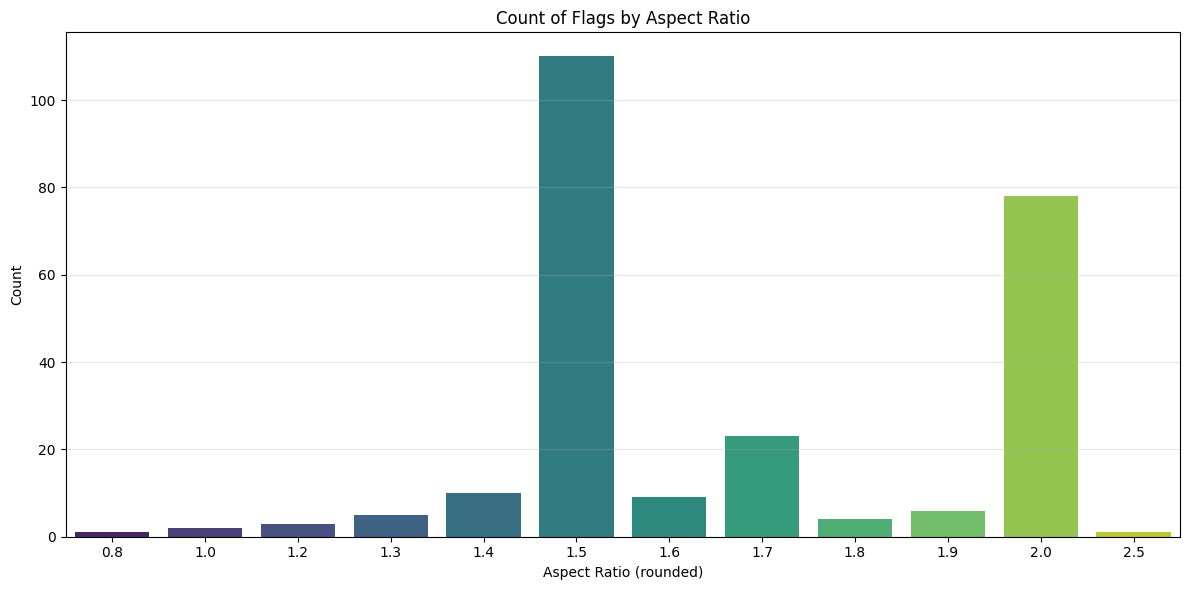

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(x=aspect_ratio_counts.index, y=aspect_ratio_counts.values, palette='viridis')
plt.title('Count of Flags by Aspect Ratio')
plt.xlabel('Aspect Ratio (rounded)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

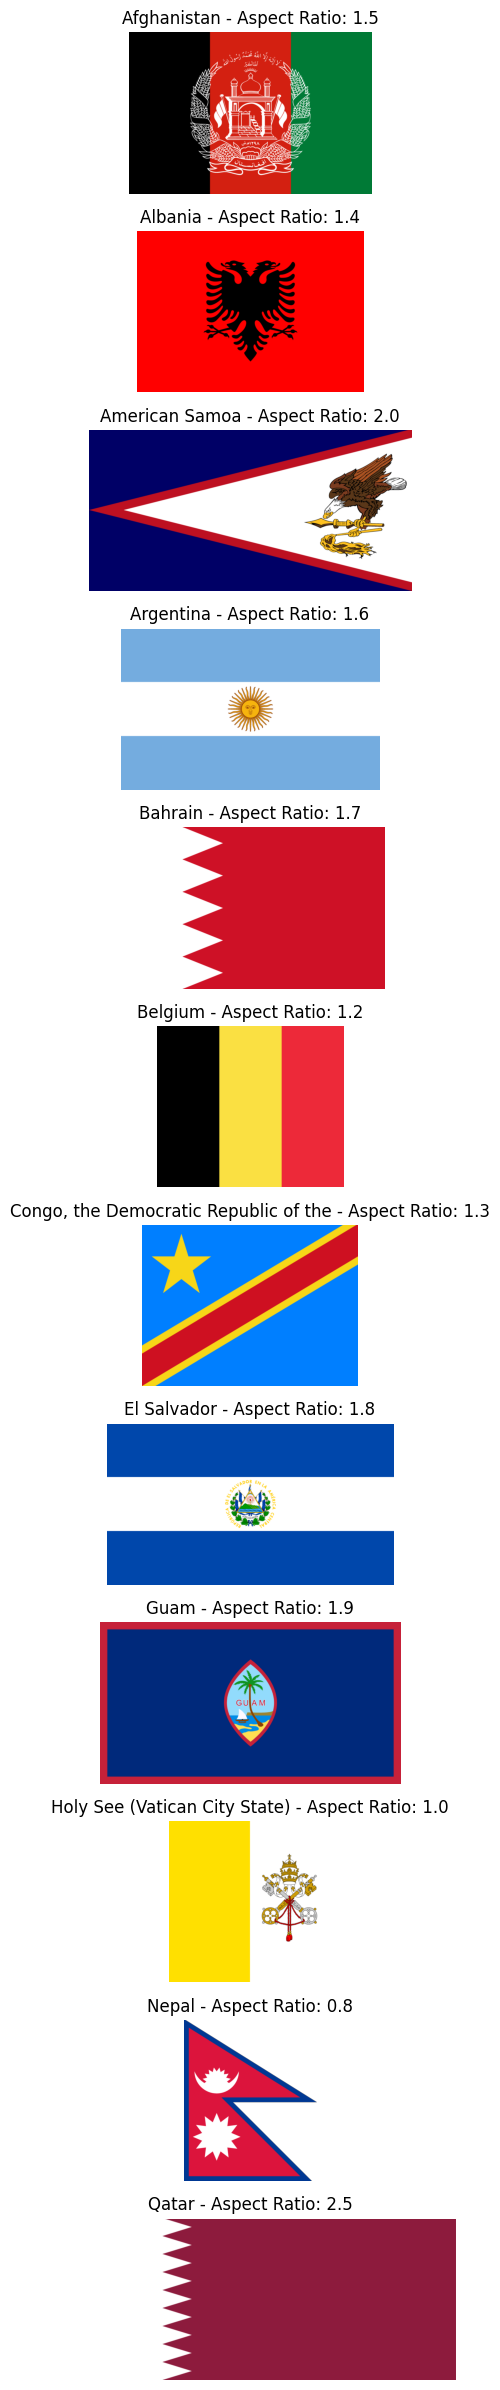

In [24]:
from IPython.display import display, Image
import matplotlib.pyplot as plt

# Get unique aspect ratios (rounded) and their corresponding flags
unique_aspect_ratios = df.drop_duplicates('aspect_ratio_rounded')

# Number of unique aspect ratios
num_aspect_ratios = len(unique_aspect_ratios)

# Create subplots
fig, axes = plt.subplots(nrows=num_aspect_ratios, ncols=1, figsize=(10, num_aspect_ratios * 2))

for ax, (index, row) in zip(axes, unique_aspect_ratios[['country', 'file', 'aspect_ratio_rounded']].iterrows()):
    image_path = os.path.join(FLAGS_DIR, row['file'])
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title(f"{row['country']} - Aspect Ratio: {row['aspect_ratio_rounded']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### COLOR ANALYSIS

C:\Users\amuaa\AppData\Local\Temp\ipykernel_11804\549989879.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dominant_color_count', data=df, palette='viridis')


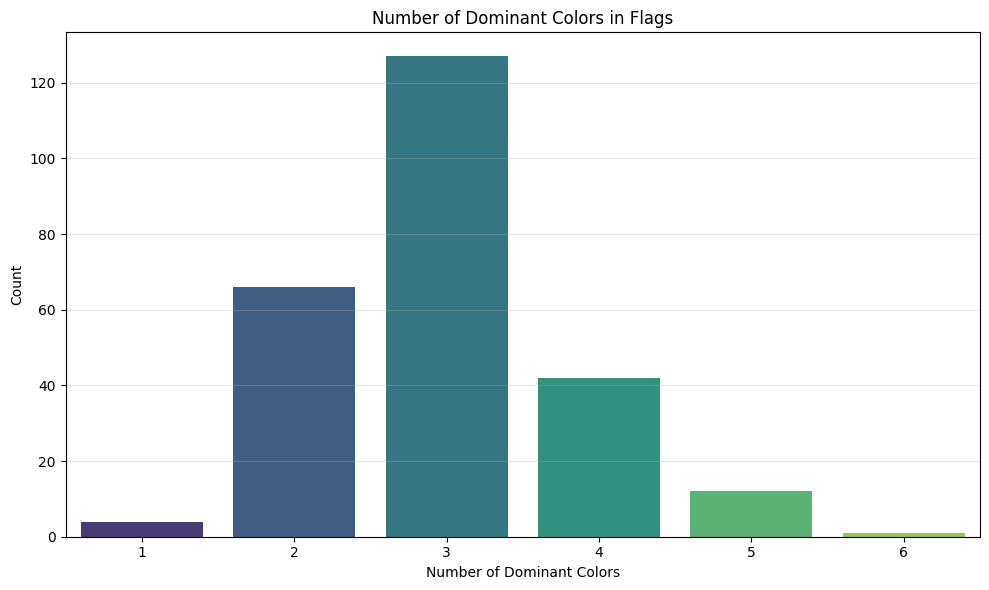

Average number of dominant colors: 2.9801587301587302


In [25]:
# 3. Analyze color counts
plt.figure(figsize=(10, 6))
sns.countplot(x='dominant_color_count', data=df, palette='viridis')
plt.title('Number of Dominant Colors in Flags')
plt.xlabel('Number of Dominant Colors')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Average number of dominant colors:", df['dominant_color_count'].mean())

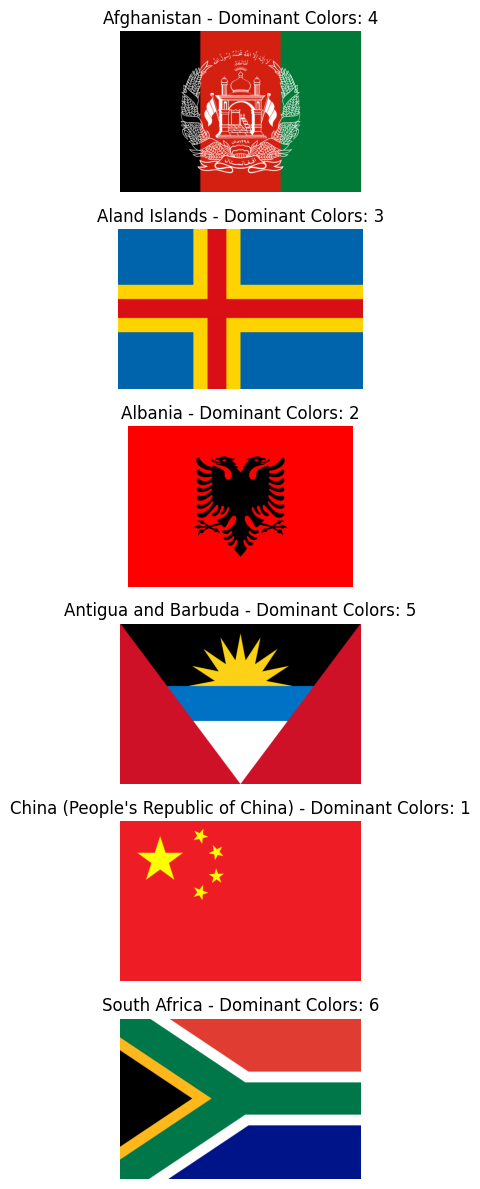

In [26]:
# Get unique dominant color counts and their corresponding flags
unique_color_counts = df.drop_duplicates('dominant_color_count')

# Number of unique color counts
num_color_counts = len(unique_color_counts)

# Create subplots
fig, axes = plt.subplots(nrows=num_color_counts, ncols=1, figsize=(10, num_color_counts * 2))

for ax, (index, row) in zip(axes, unique_color_counts[['country', 'file', 'dominant_color_count']].iterrows()):
    image_path = os.path.join(FLAGS_DIR, row['file'])
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title(f"{row['country']} - Dominant Colors: {row['dominant_color_count']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

C:\Users\amuaa\AppData\Local\Temp\ipykernel_11804\1373693136.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='horizontal_division', data=df, palette='Set2')
C:\Users\amuaa\AppData\Local\Temp\ipykernel_11804\1373693136.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vertical_division', data=df, palette='Set2')
C:\Users\amuaa\AppData\Local\Temp\ipykernel_11804\1373693136.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagonal_division', data=df, palette='Set2')


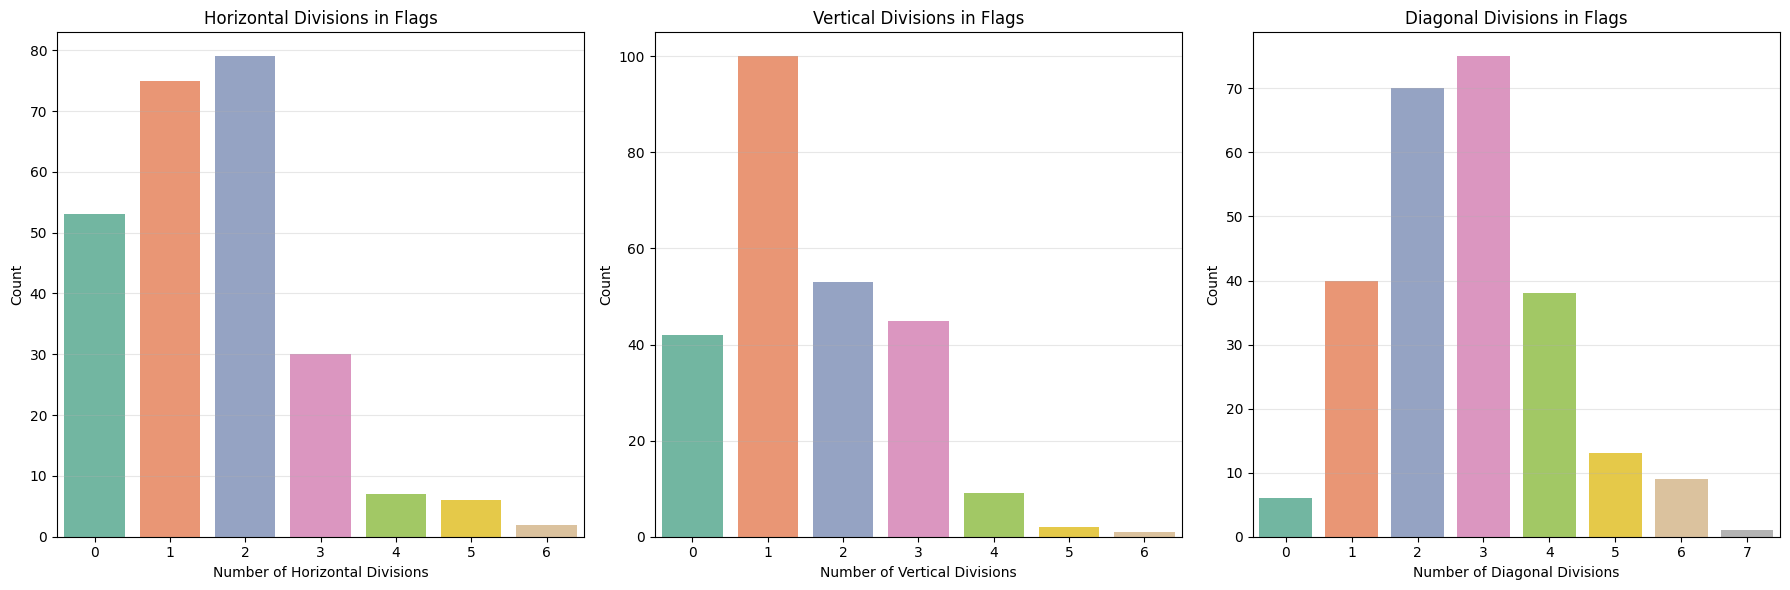

In [28]:
# 4. Analyze division patterns
plt.figure(figsize=(18, 6))

# Horizontal divisions
plt.subplot(1, 3, 1)
sns.countplot(x='horizontal_division', data=df, palette='Set2')
plt.title('Horizontal Divisions in Flags')
plt.xlabel('Number of Horizontal Divisions')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

# Vertical divisions
plt.subplot(1, 3, 2)
sns.countplot(x='vertical_division', data=df, palette='Set2')
plt.title('Vertical Divisions in Flags')
plt.xlabel('Number of Vertical Divisions')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

# Diagonal divisions
plt.subplot(1, 3, 3)
sns.countplot(x='diagonal_division', data=df, palette='Set2')
plt.title('Diagonal Divisions in Flags')
plt.xlabel('Number of Diagonal Divisions')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


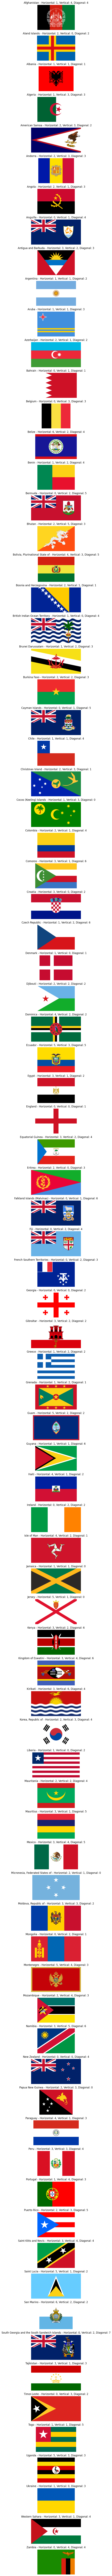

In [29]:
# Get unique division patterns and their corresponding flags
unique_divisions = df.drop_duplicates(subset=['horizontal_division', 'vertical_division', 'diagonal_division'])

# Number of unique division patterns
num_divisions = len(unique_divisions)

# Create subplots
fig, axes = plt.subplots(nrows=num_divisions, ncols=1, figsize=(10, num_divisions * 2))

for ax, (index, row) in zip(axes, unique_divisions.iterrows()):
    image_path = os.path.join(FLAGS_DIR, row['file'])
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title(f"{row['country']} - Horizontal: {row['horizontal_division']}, Vertical: {row['vertical_division']}, Diagonal: {row['diagonal_division']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [30]:
# 5. Regional analysis

def extract_region(country):
    european_countries = ['france', 'germany', 'italy', 'spain', 'uk', 'switzerland', 'netherlands', 
                         'sweden', 'norway', 'finland', 'denmark', 'belgium', 'austria', 'poland',
                         'portugal', 'greece', 'ireland', 'luxembourg', 'czechia', 'slovakia', 'hungary',
                         'slovenia', 'croatia', 'romania', 'bulgaria', 'estonia', 'latvia', 'lithuania',
                         'malta', 'cyprus', 'iceland', 'liechtenstein', 'monaco', 'andorra', 'sanmarino',
                         'vatican', 'albania', 'serbia', 'montenegro', 'macedonia', 'bosnia']
    
    african_countries = ['egypt', 'southafrica', 'nigeria', 'kenya', 'morocco', 'algeria', 'tunisia',
                        'ghana', 'ethiopia', 'uganda', 'tanzania', 'rwanda', 'sudan', 'southsudan',
                        'senegal', 'ivorycoast', 'mali', 'cameroon', 'congo', 'drcongo', 'zambia',
                        'zimbabwe', 'namibia', 'botswana', 'madagascar', 'mozambique', 'angola',
                        'libya', 'gabon', 'guinea', 'benin', 'togo', 'sierraleone', 'liberia',
                        'burundi', 'lesotho', 'swaziland', 'eritrea', 'niger', 'chad', 'mauritania',
                        'somalia', 'djibouti', 'gambia', 'malawi']
    
    asian_countries = ['china', 'japan', 'india', 'southkorea', 'northkorea', 'vietnam', 'thailand',
                      'indonesia', 'malaysia', 'singapore', 'philippines', 'myanmar', 'cambodia',
                      'laos', 'mongolia', 'nepal', 'bhutan', 'srilanka', 'bangladesh', 'pakistan',
                      'afghanistan', 'iran', 'iraq', 'syria', 'jordan', 'lebanon', 'israel',
                      'palestine', 'saudiarabia', 'uae', 'qatar', 'bahrain', 'kuwait', 'oman',
                      'yemen', 'kazakhstan', 'uzbekistan', 'turkmenistan', 'kyrgyzstan', 'tajikistan',
                      'azerbaijan', 'armenia', 'georgia', 'turkey', 'cyprus', 'brunei', 'timor']
    
    american_countries = ['usa', 'canada', 'mexico', 'brazil', 'argentina', 'chile', 'peru',
                         'colombia', 'venezuela', 'ecuador', 'bolivia', 'paraguay', 'uruguay',
                         'guyana', 'suriname', 'frenchguiana', 'belize', 'guatemala', 'elsalvador',
                         'honduras', 'nicaragua', 'costarica', 'panama', 'cuba', 'jamaica',
                         'haiti', 'dominicanrepublic', 'puertorico', 'bahamas', 'barbados',
                         'trinidadandtobago', 'grenada', 'stlucia', 'stvincent', 'dominica']
    
    oceania_countries = ['australia', 'newzealand', 'papuanewguinea', 'fiji', 'solomonislands',
                        'vanuatu', 'samoa', 'tonga', 'tuvalu', 'kiribati', 'palau', 'micronesia',
                        'marshallislands', 'nauru']
    
    country_lower = country.lower()
    
    if country_lower in european_countries:
        return 'Europe'
    elif country_lower in african_countries:
        return 'Africa'
    elif country_lower in asian_countries:
        return 'Asia'
    elif country_lower in american_countries:
        return 'Americas'
    elif country_lower in oceania_countries:
        return 'Oceania'
    else:
        # Try to detect based on naming patterns
        if any(term in country_lower for term in ['stan', 'arabia', 'emirates', 'korea', 'china', 'japan']):
            return 'Asia'
        elif any(term in country_lower for term in ['island', 'zealand', 'australia']):
            return 'Oceania'
        return 'Unknown'
    
# Add region to DataFrame
df['region'] = df['country'].apply(extract_region)



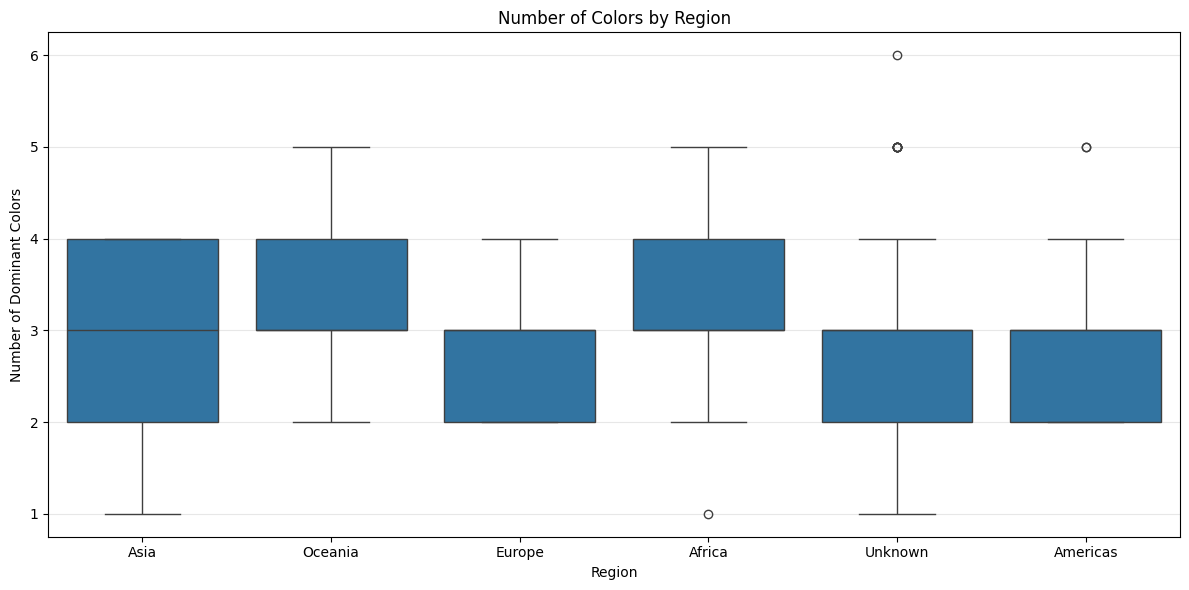

In [31]:
# Analyze color count by region
plt.figure(figsize=(12, 6))
sns.boxplot(x='region', y='dominant_color_count', data=df)
plt.title('Number of Colors by Region')
plt.xlabel('Region')
plt.ylabel('Number of Dominant Colors')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

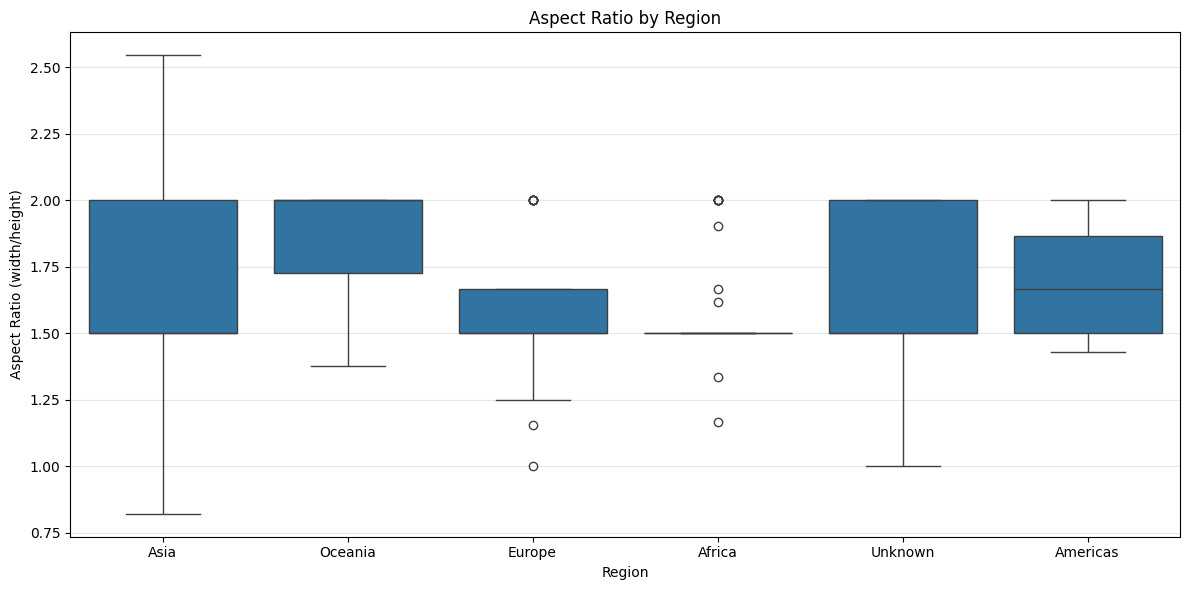

In [32]:
# Analyze aspect ratio by region
plt.figure(figsize=(12, 6))
sns.boxplot(x='region', y='aspect_ratio', data=df)
plt.title('Aspect Ratio by Region')
plt.xlabel('Region')
plt.ylabel('Aspect Ratio (width/height)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


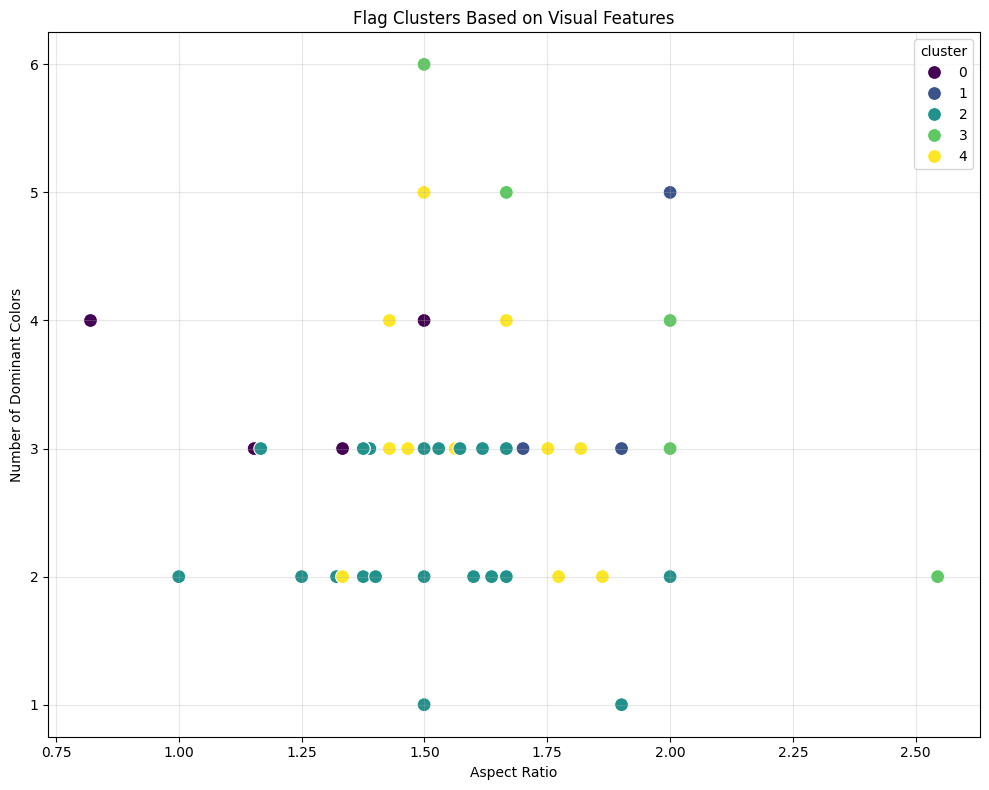

Cluster 0 contains 49 flags:
Algeria, Barbados, Belgium, Benin, Cameroon, Central African Republic, Chad, Cote d'Ivoire, Czech Republic, Djibouti, ...

Cluster 1 contains 35 flags:
Anguilla, Australia, Belarus, Bermuda, Bosnia and Herzegovina, British Indian Ocean Territory, Brunei Darussalam, Cape Verde, Cayman Islands, Cook Islands, ...

Cluster 2 contains 80 flags:
Aland Islands, Albania, Angola, Argentina, Aruba, Austria, Bahrain, Bangladesh, Botswana, Bouvet Island, ...

Cluster 3 contains 36 flags:
Antigua and Barbuda, Armenia, Azerbaijan, Bahamas, Christmas Island, Comoros, Cuba, Ethiopia, Gambia, Guinea-Bissau, ...

Cluster 4 contains 52 flags:
Afghanistan, American Samoa, Andorra, Antarctica, Belize, Bhutan, Bolivia, Plurinational State of, Brazil, Cambodia, Cocos (Keeling) Islands, ...



In [35]:

# 6. Flag similarity analysis
features = df[['aspect_ratio', 'dominant_color_count', 
               'horizontal_division', 'vertical_division', 
                'has_symbol']].copy()

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform clustering
from sklearn.cluster import KMeans
n_clusters = 5  # Can be adjusted
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='aspect_ratio', y='dominant_color_count', 
                hue='cluster', data=df, palette='viridis', s=100)
plt.title('Flag Clusters Based on Visual Features')
plt.xlabel('Aspect Ratio')
plt.ylabel('Number of Dominant Colors')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print flag clusters
for cluster in range(n_clusters):
    cluster_flags = df[df['cluster'] == cluster]['country'].tolist()
    print(f"Cluster {cluster} contains {len(cluster_flags)} flags:")
    print(', '.join(cluster_flags[:10]) + (', ...' if len(cluster_flags) > 10 else ''))
    print()



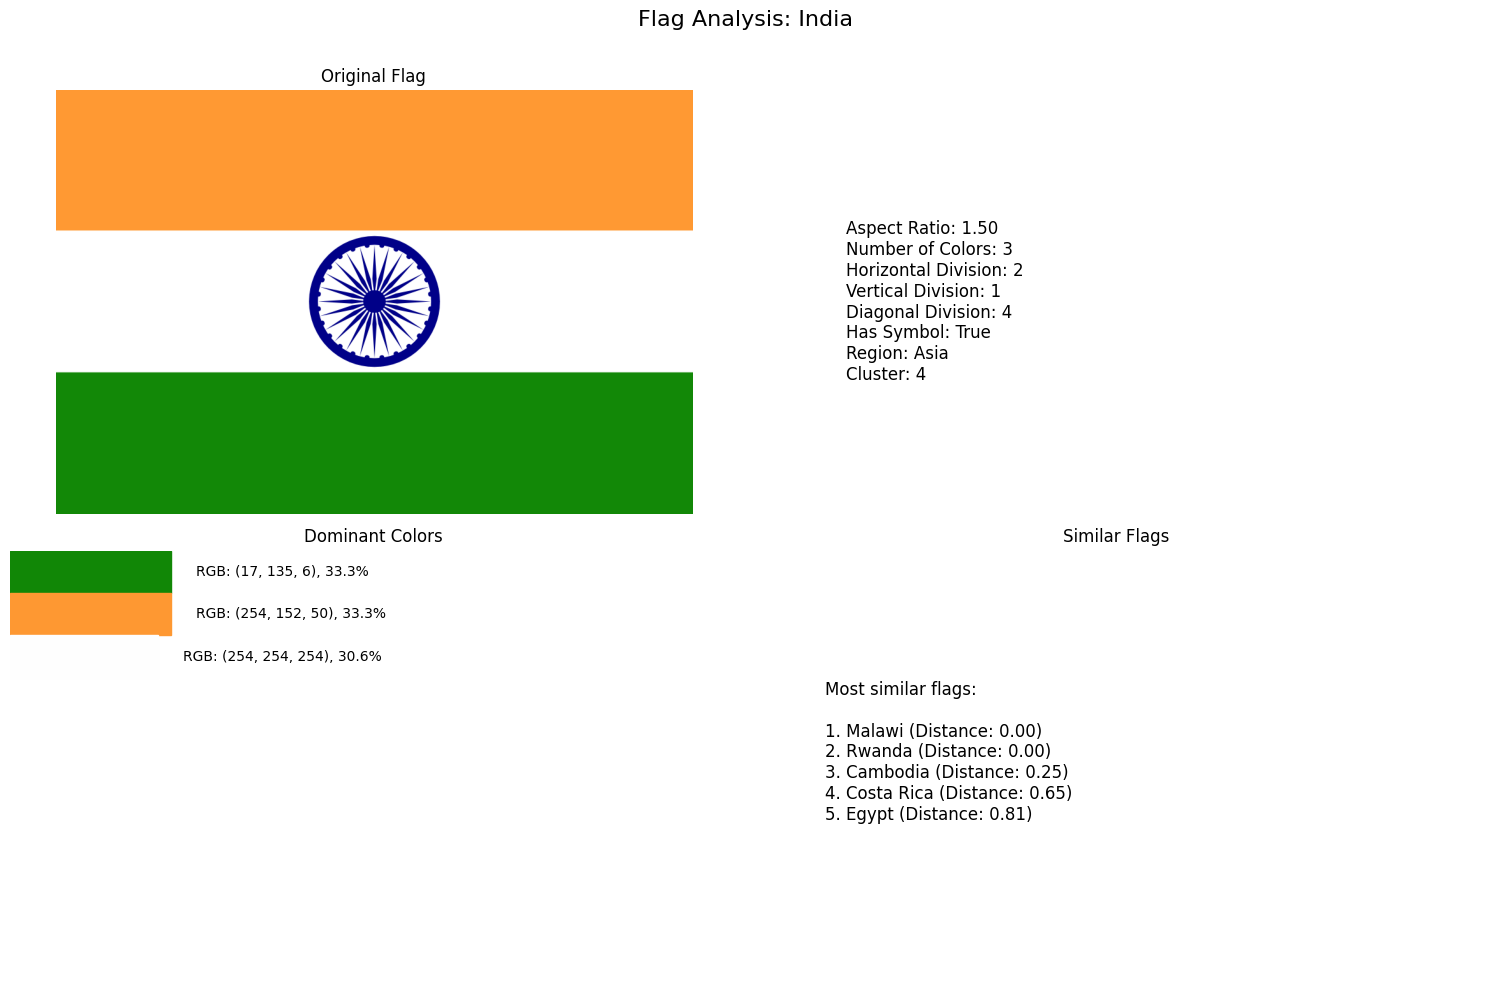

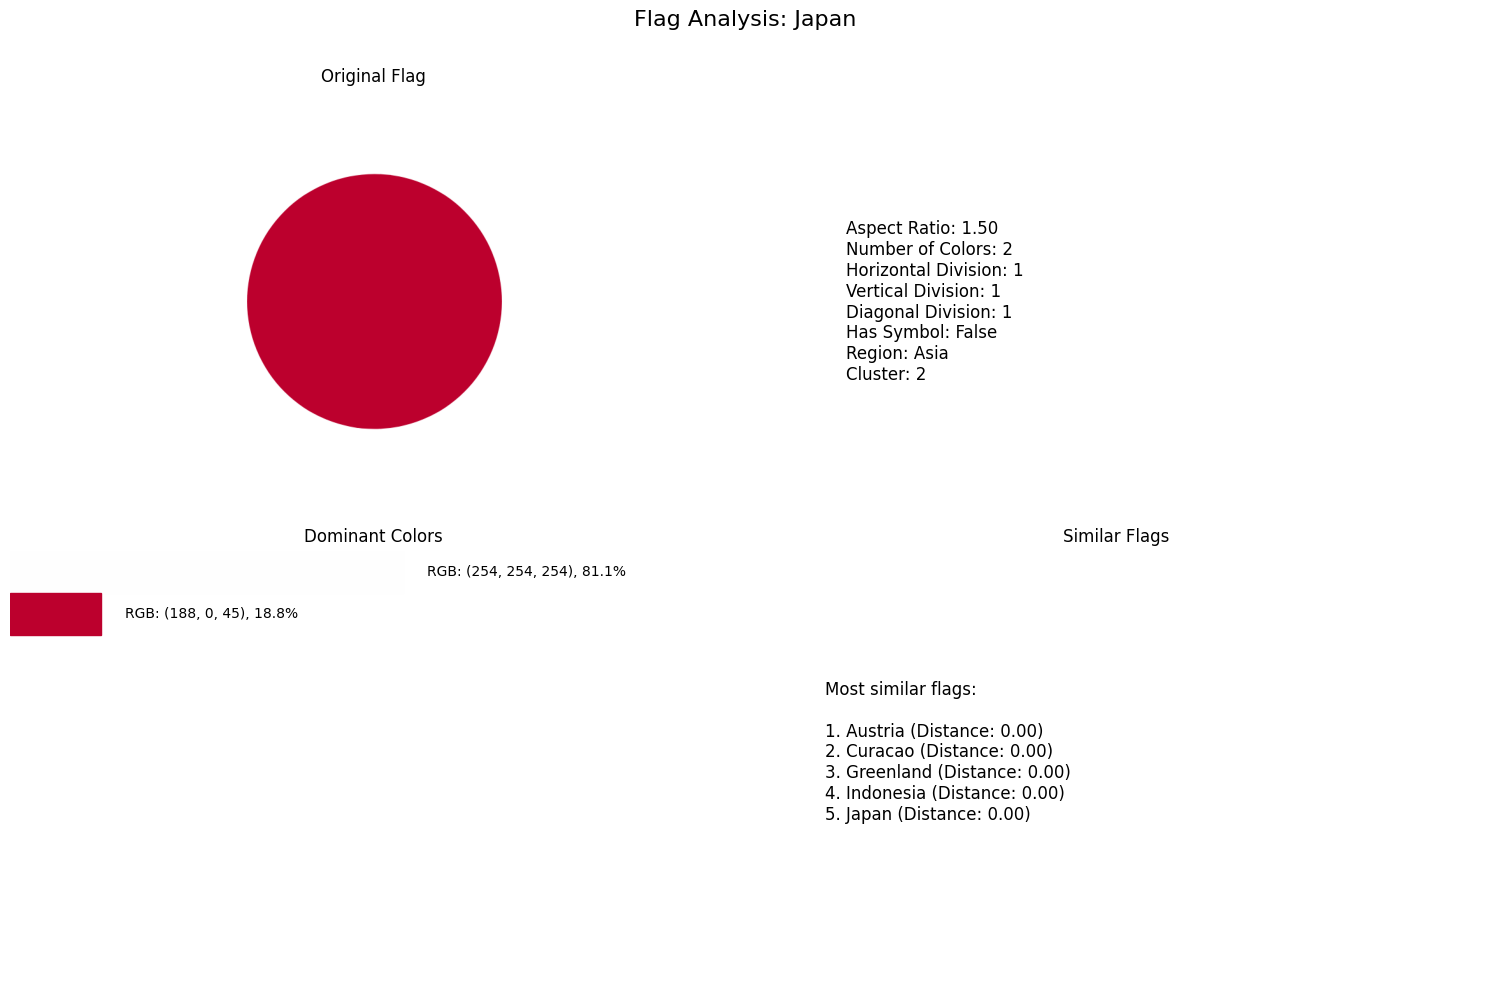

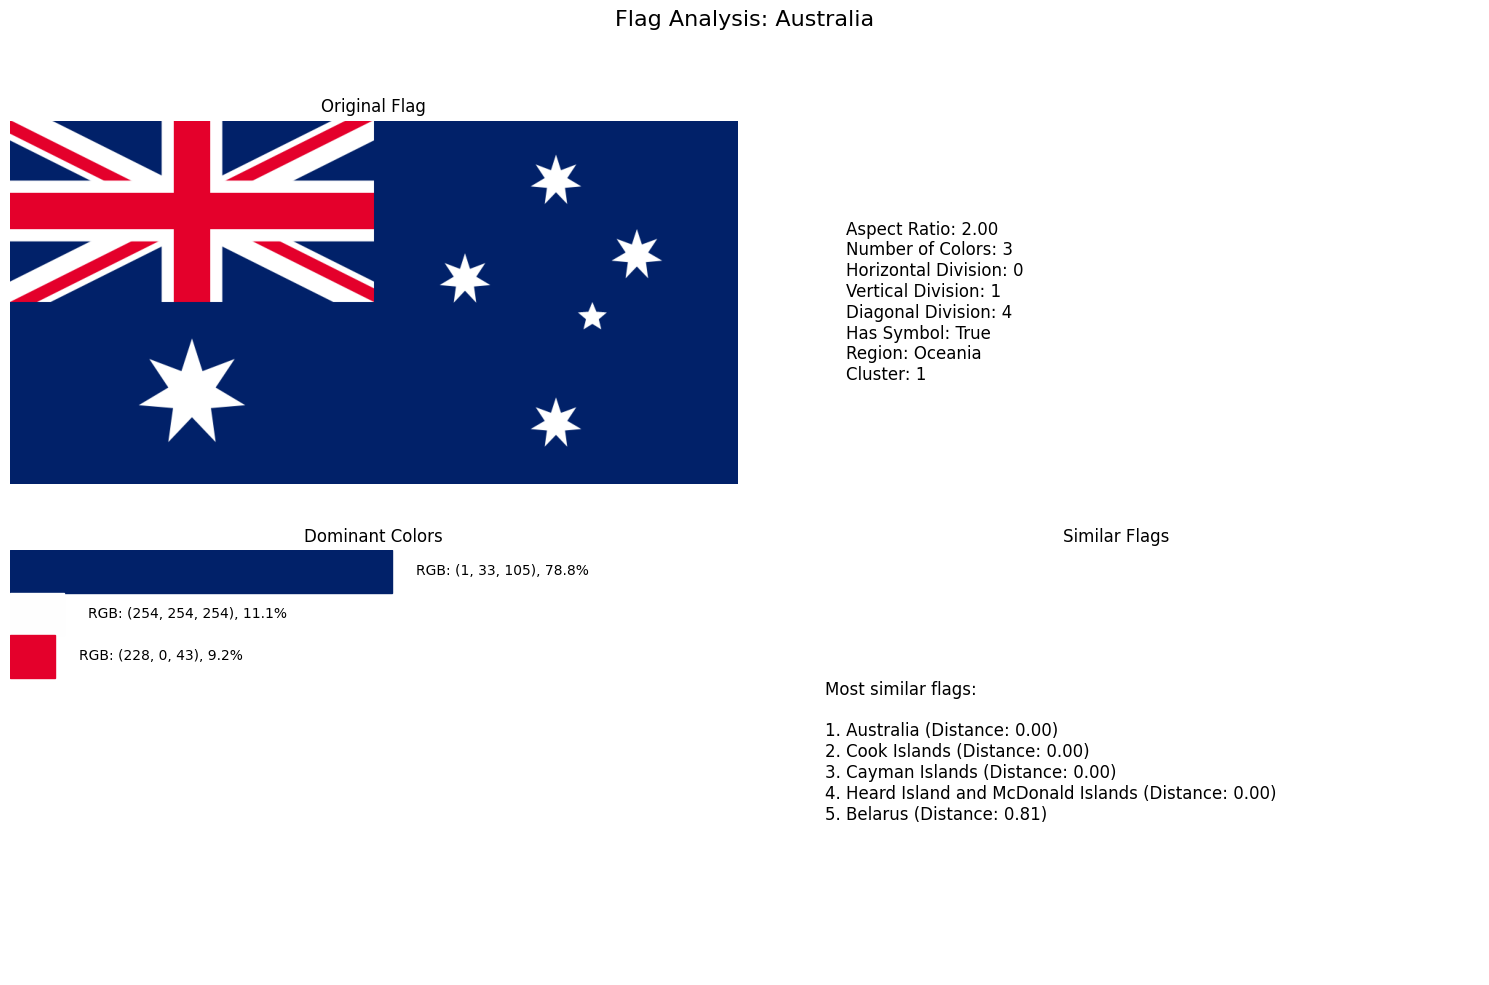

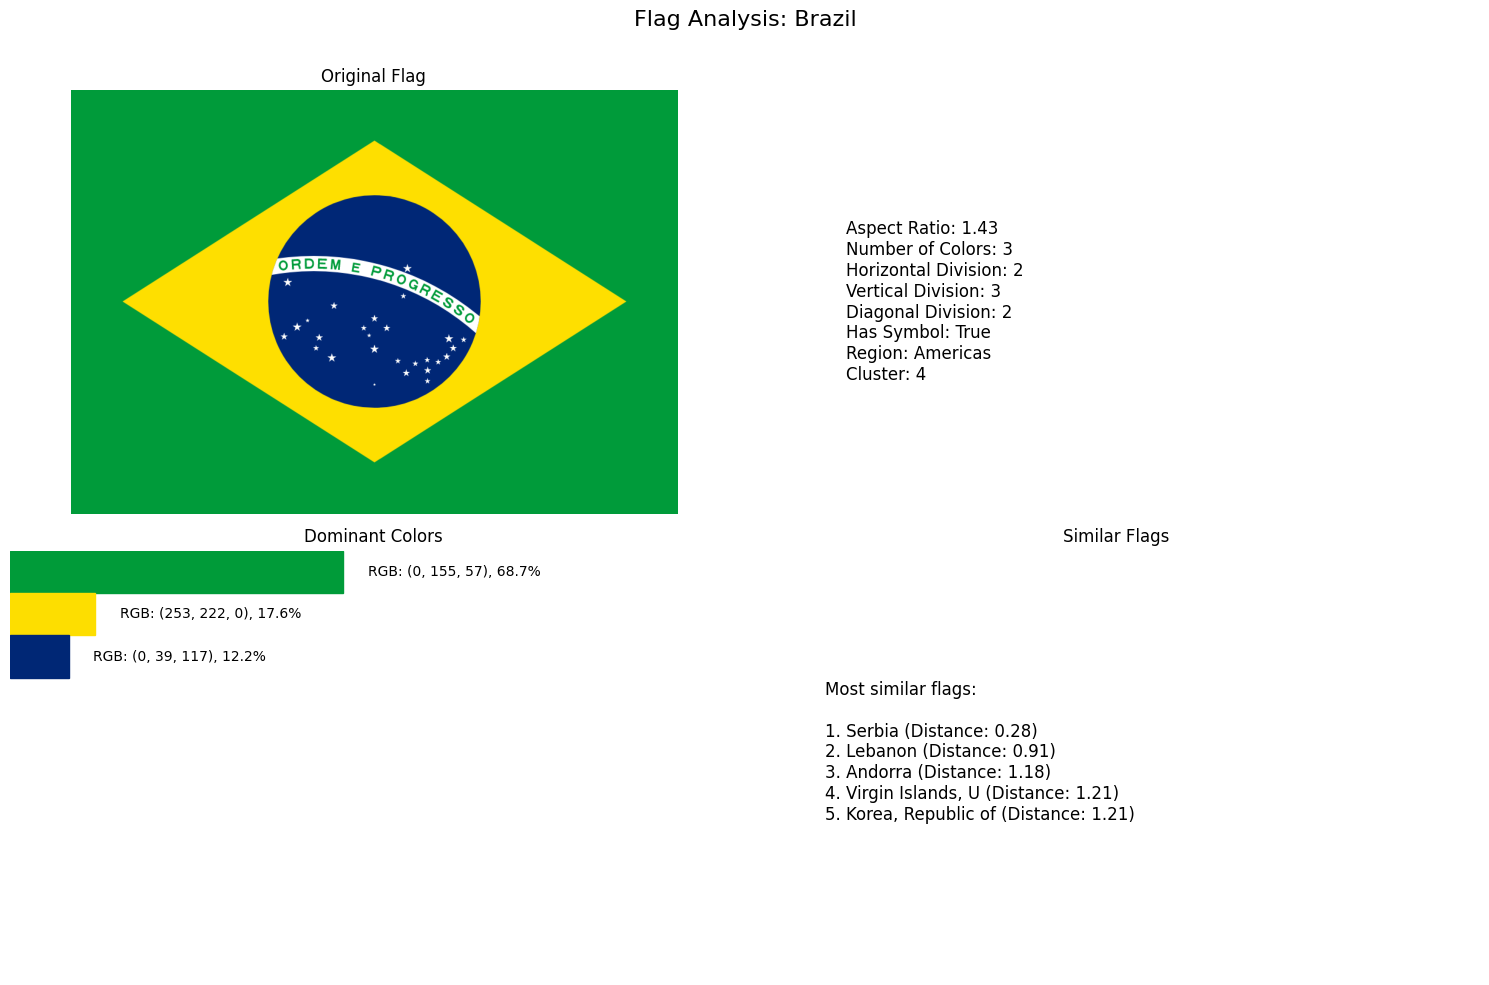

c:\Users\amuaa\my_env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


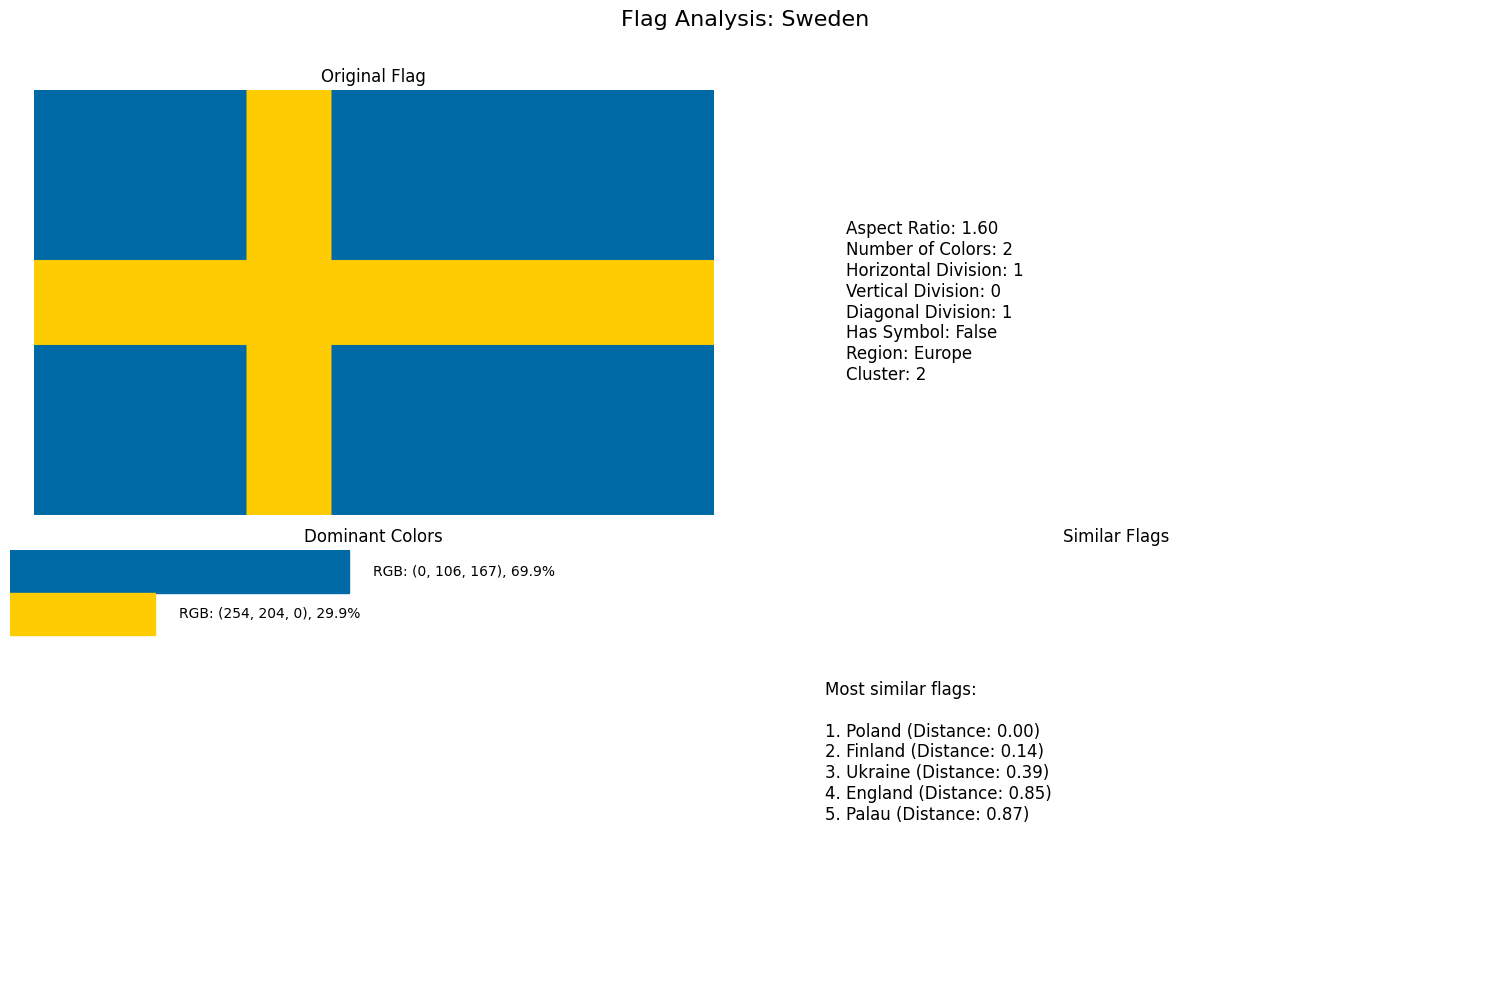

In [37]:
# 7.flag visualization
def visualize_flag_analysis(country_name):
    # Find the country in our dataset
    country_data = df[df['country'].str.lower() == country_name.lower()]
    
    if len(country_data) == 0:
        print(f"Country '{country_name}' not found in dataset")
        return
    country_info = country_data.iloc[0]
    
    # Load the image
    file_path = os.path.join(FLAGS_DIR, country_info['file'])
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create a figure
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Flag Analysis: {country_info["country"]}', fontsize=16)

        # Plot the flag
    axs[0, 0].imshow(img_rgb)
    axs[0, 0].set_title('Original Flag')
    axs[0, 0].axis('off')
    
    # Display flag metrics
    axs[0, 1].axis('off')
    info_text = f"""
    Aspect Ratio: {country_info['aspect_ratio']:.2f}
    Number of Colors: {country_info['dominant_color_count']}
    Horizontal Division: {country_info['horizontal_division']}
    Vertical Division: {country_info['vertical_division']}
    Diagonal Division: {country_info['diagonal_division']}
    Has Symbol: {country_info['has_symbol']}
    Region: {country_info['region']}
    Cluster: {country_info['cluster']}
    """
    axs[0, 1].text(0.1, 0.5, info_text, fontsize=12, verticalalignment='center')

    # Show color extraction
    pixels = img_rgb.reshape(-1, 3)
    n_colors = 8
    kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(pixels)
    centers = kmeans.cluster_centers_
    
    # Sort colors by frequency
    counts = Counter(kmeans.labels_)
    color_data = []
    for i in range(n_colors):
        proportion = counts[i] / len(pixels)
        if proportion > 0.03:  # Skip very small proportions
            color_data.append((tuple(map(int, centers[i])), proportion))
    
    # Sort by proportion
    color_data.sort(key=lambda x: x[1], reverse=True)
    
    # Plot color proportions
    axs[1, 0].set_title('Dominant Colors')
    axs[1, 0].axis('off')

    for i, (color, proportion) in enumerate(color_data):
        axs[1, 0].add_patch(Rectangle((0, 1-i*0.1-0.1), proportion, 0.1, 
                                     color=[c/255 for c in color]))
        axs[1, 0].text(proportion+0.05, 1-i*0.1-0.05, 
                      f"RGB: {color}, {proportion:.1%}", 
                      va='center', ha='left')
    
    axs[1, 0].set_xlim(0, 1.5)
    axs[1, 0].set_ylim(0, 1)
    
    # Find similar flags
    from sklearn.metrics.pairwise import euclidean_distances
    
    # Get features for the current flag
    current_features = features_scaled[country_data.index[0]].reshape(1, -1)
    
    # Calculate distances to all other flags
    distances = euclidean_distances(current_features, features_scaled)[0]
    
    # Create a DataFrame with distances
    distance_df = pd.DataFrame({
        'country': df['country'],
        'distance': distances
    })

    # Sort by distance and get top 5 similar flags (excluding the current flag)
    similar_flags = distance_df.sort_values('distance')[1:6]
    
    # Plot similar flags info
    axs[1, 1].set_title('Similar Flags')
    axs[1, 1].axis('off')
    similar_text = "Most similar flags:\n\n"
    for i, (idx, row) in enumerate(similar_flags.iterrows()):
        similar_text += f"{i+1}. {row['country']} (Distance: {row['distance']:.2f})\n"
    
    axs[1, 1].text(0.1, 0.5, similar_text, fontsize=12, verticalalignment='center')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    return country_info

for country in ['India', 'Japan', 'Australia', 'Brazil', 'Sweden']:
    try:
        visualize_flag_analysis(country)
    except Exception as e:
        print(f"Error visualizing {country}: {e}")



     

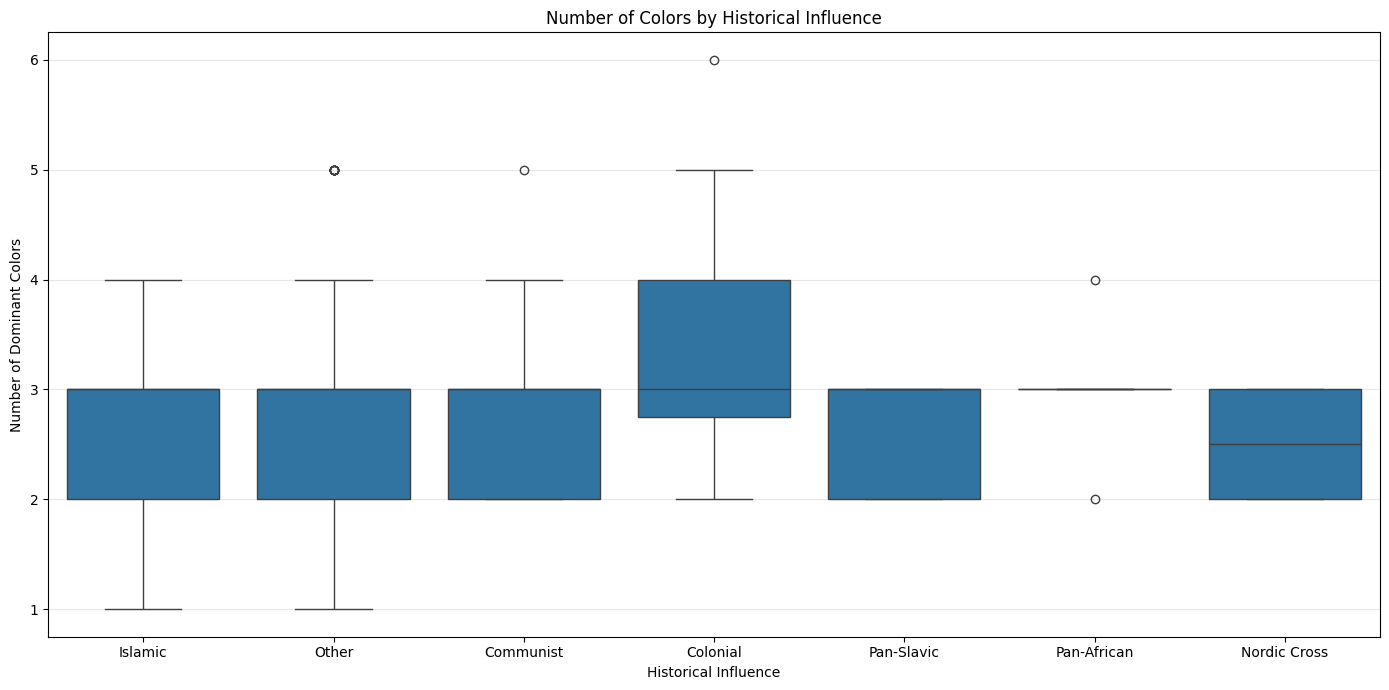

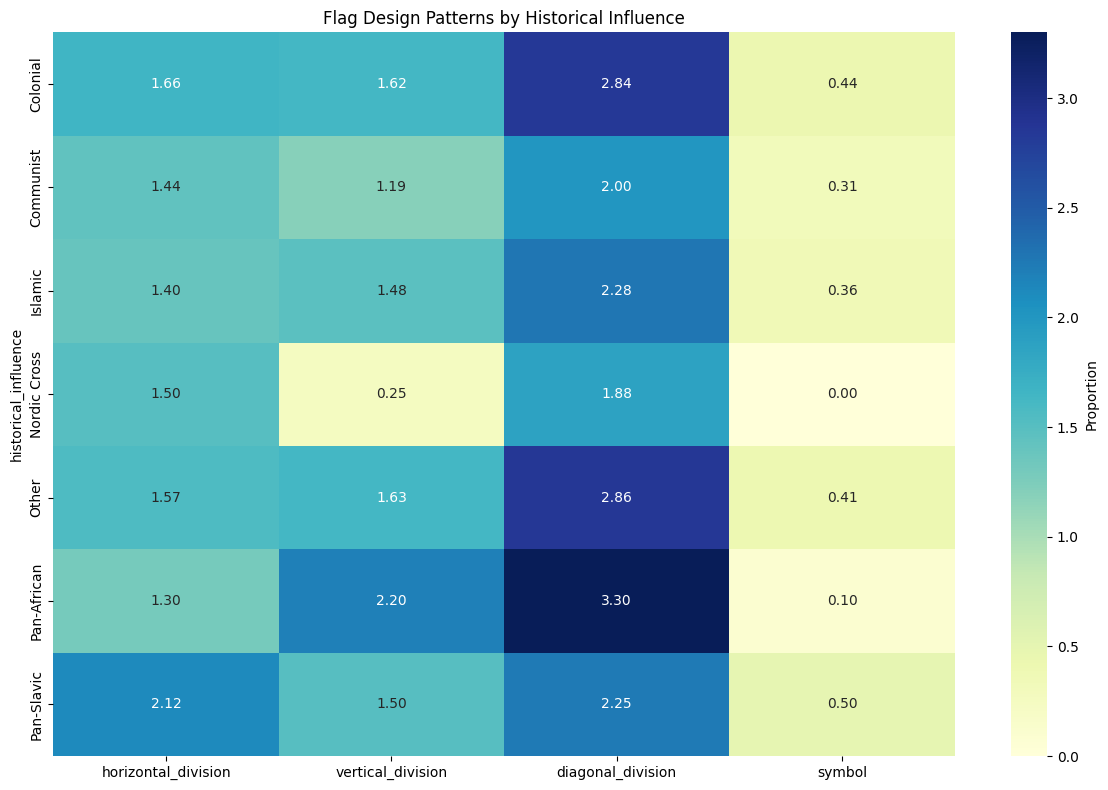

In [40]:

# 8. Advanced Analysis: Flag Patterns by Historical Development

# Colonial Influence (British & Other European Empires)
colonial_influence = [
    'Australia', 'New Zealand', 'Canada', 'Jamaica', 'Barbados', 'Bahamas', 
    'Fiji', 'Singapore', 'Malaysia', 'Kenya', 'Nigeria', 'South Africa',
    'India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Myanmar', 'Ghana', 'Tanzania',
    'Uganda', 'Zimbabwe', 'Zambia', 'Botswana', 'Malawi', 'Sierra Leone',
    'Trinidad and Tobago', 'Guyana', 'Papua New Guinea', 'Belize',
    'Malta', 'Cyprus', 'Sudan', 'Hong Kong'
]

# Islamic Influence (Countries with strong Islamic heritage and governance)
islamic_influence = [
    'Turkey', 'Saudi Arabia', 'Pakistan', 'Indonesia', 'Morocco', 'Algeria',
    'Tunisia', 'Egypt', 'Iran', 'Iraq', 'Malaysia', 'Jordan', 'UAE', 'Qatar',
    'Kuwait', 'Bahrain', 'Oman', 'Yemen', 'Sudan', 'Somalia', 'Afghanistan',
    'Syria', 'Lebanon', 'Libya', 'Chad', 'Mauritania', 'Brunei', 'Maldives',
    'Turkmenistan', 'Uzbekistan', 'Kazakhstan', 'Kyrgyzstan', 'Djibouti'
]

# Communist Influence (Past & Present Communist States)
communist_influence = [
    'China', 'Vietnam', 'Cuba', 'North Korea', 'Laos',
    'Russia', 'Mongolia', 'Belarus', 'Ukraine', 'Poland',
    'Romania', 'Hungary', 'East Germany', 'Czechoslovakia', 'Yugoslavia',
    'Bulgaria', 'Albania', 'Venezuela', 'Angola', 'Mozambique', 'Cambodia',
    'Nicaragua', 'Ethiopia', 'Grenada'
]

# Pan-African (Countries leading African unity movements)
pan_african = [
    'Ghana', 'Ethiopia', 'Senegal', 'Mali', 'Guinea', 'Cameroon', 'Congo',
    'Kenya', 'Tanzania', 'Uganda', 'Zimbabwe', 'Zambia', 'South Africa',
    'Namibia', 'Angola', 'Burkina Faso', 'Nigeria', 'Rwanda', 'Ivory Coast',
    'Sudan', 'Somalia', 'Liberia', 'Botswana', 'Chad', 'Madagascar', 'Gabon',
    'Mozambique', 'Algeria'
]

# Pan-Slavic (Slavic nations with strong shared identity)
pan_slavic = [
    'Russia', 'Serbia', 'Slovenia', 'Slovakia', 'Croatia', 'Czechia', 'Bulgaria',
    'Ukraine', 'Belarus', 'Montenegro', 'Bosnia and Herzegovina', 'North Macedonia',
    'Poland', 'Moldova', 'Kosovo'
]

# Nordic Cross (Nordic Countries with traditional Scandinavian cross flag & culture)
nordic_cross = [
    'Sweden', 'Norway', 'Denmark', 'Finland', 'Iceland',
    'Greenland', 'Faroe Islands', 'Åland Islands', 'Estonia'  
]


# Function to assign historical influence
def assign_historical_influence(country):
    country_lower = country.lower()
    
    if country in colonial_influence:
        return 'Colonial'
    elif country in islamic_influence:
        return 'Islamic'
    elif country in communist_influence:
        return 'Communist'
    elif country in pan_african:
        return 'Pan-African'
    elif country in pan_slavic:
        return 'Pan-Slavic'
    elif country in nordic_cross:
        return 'Nordic Cross'
    else:
        return 'Other'


df['historical_influence'] = df['country'].apply(assign_historical_influence)

# Analyze color count by historical influence
plt.figure(figsize=(14, 7))
sns.boxplot(x='historical_influence', y='dominant_color_count', data=df)
plt.title('Number of Colors by Historical Influence')
plt.xlabel('Historical Influence')
plt.ylabel('Number of Dominant Colors')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze divisions by historical influence
historical_groups = df.groupby('historical_influence')

results = []
for group_name, group in historical_groups:
    horizontal = group['horizontal_division'].mean()
    vertical = group['vertical_division'].mean()
    diagonal = group['diagonal_division'].mean()
    symbol = group['has_symbol'].mean()
    
    results.append({
        'historical_influence': group_name,
        'horizontal_division': horizontal,
        'vertical_division': vertical,
        'diagonal_division': diagonal,
        'symbol': symbol
    })

historical_patterns_df = pd.DataFrame(results)

# Plot as heatmap
plt.figure(figsize=(12, 8))
historical_patterns_pivot = historical_patterns_df.set_index('historical_influence')
sns.heatmap(historical_patterns_pivot, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Proportion'})
plt.title('Flag Design Patterns by Historical Influence')
plt.tight_layout()
plt.show()

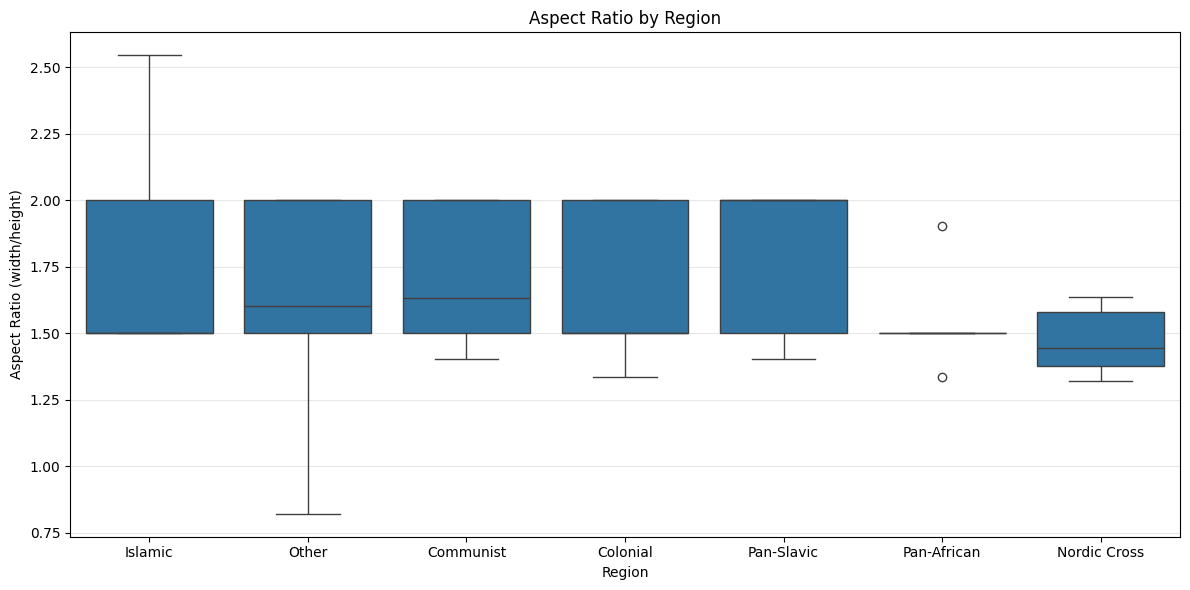

In [41]:
# Analyze aspect ratio by historical influence
plt.figure(figsize=(12, 6))
sns.boxplot(x='historical_influence', y='aspect_ratio', data=df)
plt.title('Aspect Ratio by Region')
plt.xlabel('Region')
plt.ylabel('Aspect Ratio (width/height)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\amuaa\AppData\Local\Temp\ipykernel_11804\900232077.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Color', y='Count', data=color_usage_df, palette='viridis')


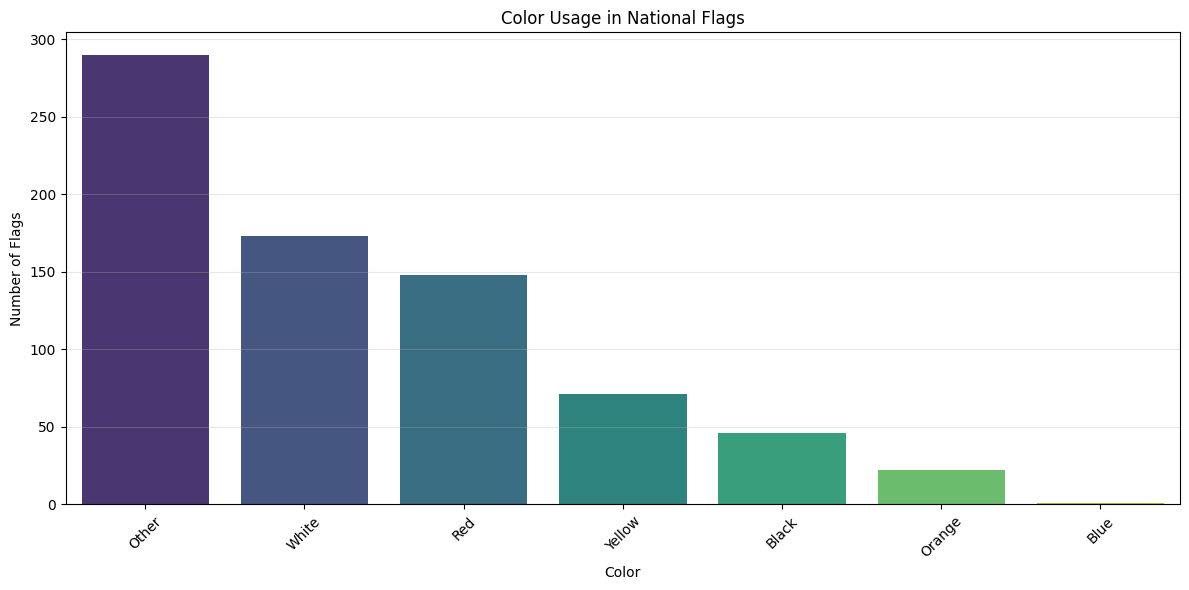

In [42]:

# 9. Color Palettes Analysis

# Function to extract simplified color palette
def get_simplified_colors(colors):
    """Convert RGB colors to simplified color names"""
    simplified_colors = []
    
    for color in colors:
        r, g, b = color
        
        # Check for white/black
        if r > 220 and g > 220 and b > 220:
            simplified_colors.append('White')
        elif r < 35 and g < 35 and b < 35:
            simplified_colors.append('Black')
        # Check for primary colors
        elif r > 200 and g < 100 and b < 100:
            simplified_colors.append('Red')
        elif r < 100 and g > 200 and b < 100:
            simplified_colors.append('Green')
        elif r < 100 and g < 100 and b > 200:
            simplified_colors.append('Blue')
        # Check for secondary colors
        elif r > 200 and g > 200 and b < 100:
            simplified_colors.append('Yellow')
        elif r > 200 and g < 100 and b > 200:
            simplified_colors.append('Purple')
        elif r < 100 and g > 200 and b > 200:
            simplified_colors.append('Cyan')
        elif r > 200 and g > 120 and b < 100:
            simplified_colors.append('Orange')
        else:
            simplified_colors.append('Other')
    
    return simplified_colors

# Apply color simplification
df['simplified_colors'] = df['colors'].apply(get_simplified_colors)

# Function to count color occurrences
def count_color_usage(colors_list):
    result = {}
    for color_list in colors_list:
        for color in color_list:
            if color in result:
                result[color] += 1
            else:
                result[color] = 1
    return result

# Count color usage
color_usage = count_color_usage(df['simplified_colors'])

# Convert to DataFrame for visualization
color_usage_df = pd.DataFrame(list(color_usage.items()), columns=['Color', 'Count'])
color_usage_df = color_usage_df.sort_values('Count', ascending=False)

# Plot color usage
plt.figure(figsize=(12, 6))
sns.barplot(x='Color', y='Count', data=color_usage_df, palette='viridis')
plt.title('Color Usage in National Flags')
plt.xlabel('Color')
plt.ylabel('Number of Flags')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most common color combinations:
Other, White: 56 flags
Other, Red, White: 49 flags
Other, Red, Yellow: 24 flags
Red, White: 17 flags
Other, Yellow: 14 flags
Black, Other, Red, White: 9 flags
Orange, Other: 9 flags
Other, Red: 7 flags
Other, Red, White, Yellow: 6 flags
Black, Other, White: 6 flags


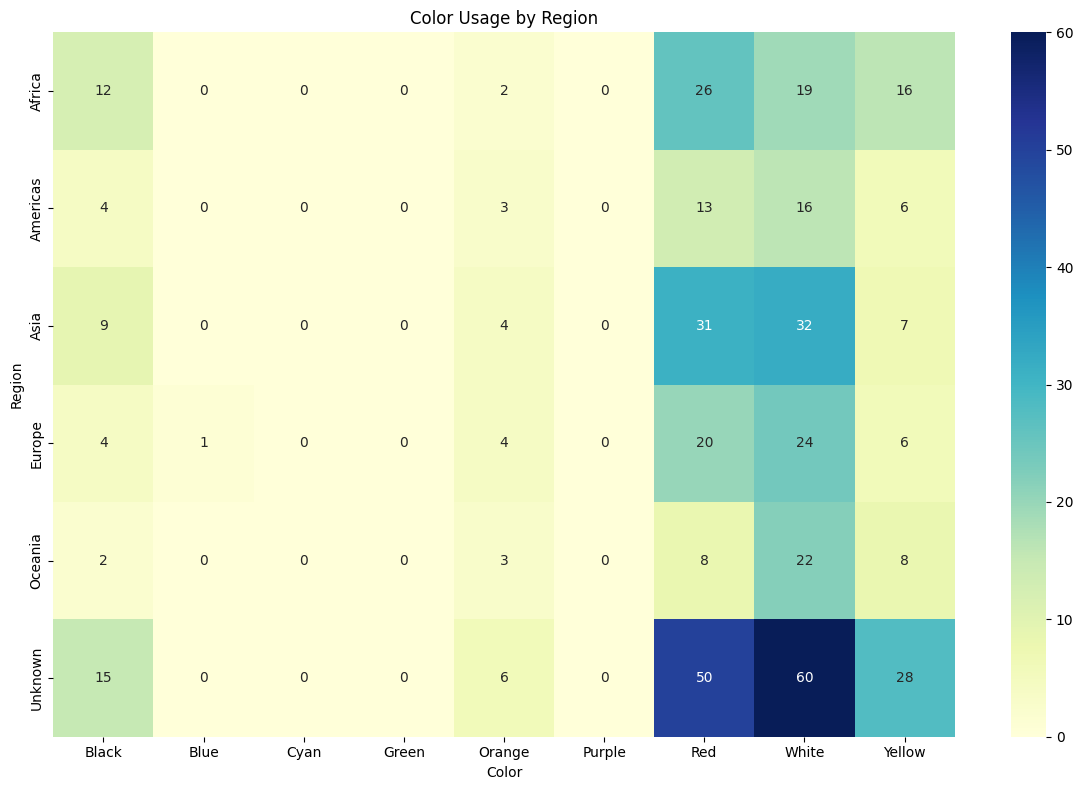

In [43]:
# 10. Analysis of Common Color Combinations

# Function to convert color list to a sorted tuple for counting
def get_color_set(colors):
    return tuple(sorted(set(colors)))

# Count color combinations
color_combinations = df['simplified_colors'].apply(get_color_set)
color_combo_counts = color_combinations.value_counts()

# Print top combinations
print("Most common color combinations:")
for combo, count in color_combo_counts.head(10).items():
    print(f"{', '.join(combo)}: {count} flags")

# 11. Analyze regional trends in color usage

# Function to calculate color usage by region
def color_usage_by_region(df):
    regions = df['region'].unique()
    color_names = ['Red', 'Green', 'Blue', 'Yellow', 'White', 'Black', 'Orange', 'Purple', 'Cyan']
    
    # Initialize results dictionary
    results = {region: {color: 0 for color in color_names} for region in regions}
    
    # Count occurrences
    for _, row in df.iterrows():
        region = row['region']
        colors = row['simplified_colors']
        
        for color in colors:
            if color in color_names:
                results[region][color] += 1
    
    # Convert to DataFrame
    result_df = []
    for region in regions:
        for color, count in results[region].items():
            result_df.append({
                'Region': region,
                'Color': color,
                'Count': count
            })
    
    return pd.DataFrame(result_df)

# Get color usage by region
color_by_region = color_usage_by_region(df)

# Plot as heatmap
plt.figure(figsize=(12, 8))
color_by_region_pivot = color_by_region.pivot(index='Region', columns='Color', values='Count')
sns.heatmap(color_by_region_pivot, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Color Usage by Region')
plt.tight_layout()
plt.show()

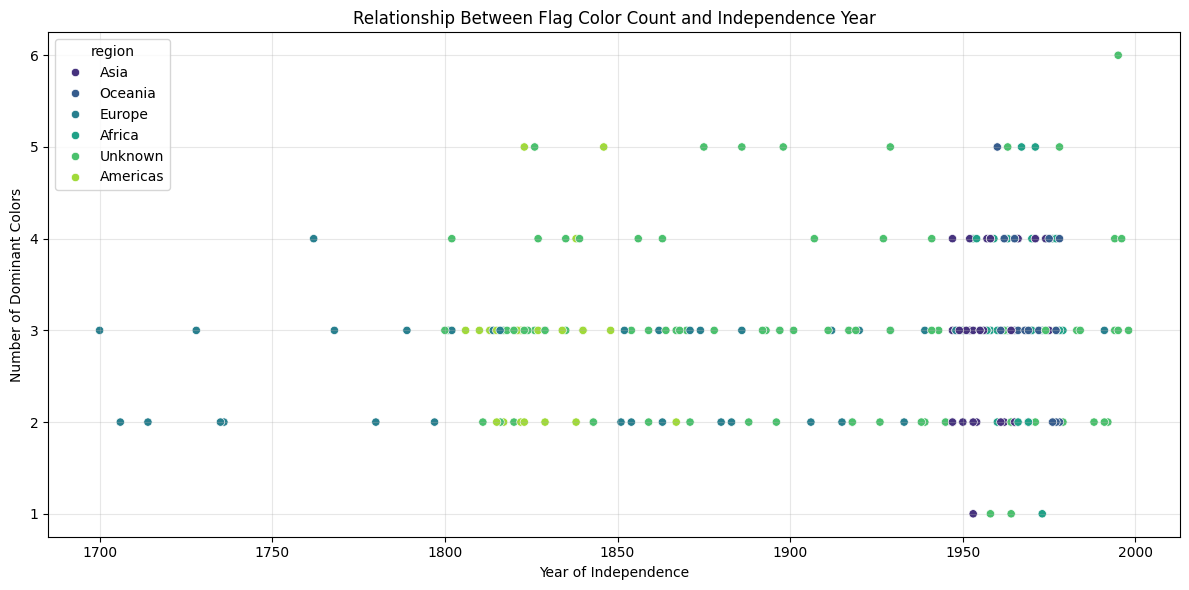

In [44]:




# 12. Analyze relationship between color count and independence date


import random
random.seed(42)

# Create a dictionary of some known independence dates
independence_dates = {
    'USA': 1776,
    'France': 1789,
    'Mexico': 1821,
    'Brazil': 1822,
    'Canada': 1867,
    'Germany': 1871,
    'India': 1947,
    'Pakistan': 1947,
    'China': 1949,
    'Ghana': 1957,
    'Nigeria': 1960,
    'Kenya': 1963,
    'Singapore': 1965,
    'Croatia': 1991,
    'Ukraine': 1991,
    'SouthSudan': 2011
}

# Function to assign a plausible independence date
def assign_independence_date(country, region):
    if country in independence_dates:
        return independence_dates[country]
    elif region == 'Europe':
        return random.randint(1700, 1950)
    elif region == 'Asia':
        return random.randint(1945, 1975)
    elif region == 'Africa':
        return random.randint(1950, 1980)
    elif region == 'Americas':
        return random.randint(1800, 1850)
    elif region == 'Oceania':
        return random.randint(1960, 1980)
    else:
        return random.randint(1800, 2000)

# Add independence dates to dataframe
df['independence_year'] = df.apply(lambda row: assign_independence_date(row['country'], row['region']), axis=1)

# Analyze the relationship between color count and independence year
plt.figure(figsize=(12, 6))
sns.scatterplot(x='independence_year', y='dominant_color_count', data=df, hue='region', palette='viridis')
plt.title('Relationship Between Flag Color Count and Independence Year')
plt.xlabel('Year of Independence')
plt.ylabel('Number of Dominant Colors')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



## ANTHEM TEXT ANALYSIS

In [ ]:
pip install nltk textblob matplotlib seaborn pandas

^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached regex-2024.11.6-cp313-cp313-win_amd64.whl.metadata (41 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   --------------------------------- ------ 524.3/624.3 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 624.3/624.3 kB 1.2 MB/s eta 0:00:00
Using cached regex-2024.11.6-cp313-cp313-win_amd64.whl (273 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [47]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud


In [49]:

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define the path to the anthems folder
anthems_folder = 'anthems'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amuaa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amuaa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amuaa\AppData\Roaming\nltk_data...


In [50]:


# Function to read and preprocess an anthem text
def preprocess_anthem(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return lemmatized_tokens, text

# Function to perform sentiment analysis
def perform_sentiment_analysis(text):
    analysis = TextBlob(text)
    # Return polarity (-1 to 1) and subjectivity (0 to 1)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Function to analyze the most common words
def analyze_common_words(tokens, top_n=20):
    word_counts = Counter(tokens)
    return word_counts.most_common(top_n)

# Function to create a word cloud
def create_word_cloud(tokens, country_name):
    text = ' '.join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          max_words=100, contour_width=3, contour_color='steelblue')
    wordcloud.generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {country_name}')
    plt.tight_layout()
    plt.savefig(f'wordcloud_{country_name}.png')
    plt.close()

# Function to analyze emotional tone
def analyze_emotional_tone(text):
    # Define emotion-related word lists
    emotion_words = {
        'joy': ['joy', 'happy', 'happiness', 'love', 'glory', 'glorious', 'celebrate', 'celebration', 'triumph', 'triumphant'],
        'courage': ['brave', 'courage', 'courageous', 'strong', 'strength', 'bold', 'valor', 'valiant', 'hero', 'heroic'],
        'pride': ['pride', 'proud', 'honor', 'honour', 'noble', 'dignity', 'dignified', 'great', 'mighty', 'majesty'],
        'defiance': ['fight', 'battle', 'war', 'defend', 'defense', 'resistance', 'resist', 'struggle', 'combat', 'victory'],
        'unity': ['unite', 'unity', 'together', 'one', 'union', 'brotherhood', 'sisterhood', 'community', 'people', 'nation'],
        'sacrifice': ['sacrifice', 'blood', 'die', 'death', 'martyrdom', 'martyr', 'fell', 'fallen', 'loss', 'lost'],
        'hope': ['hope', 'future', 'promise', 'dream', 'aspire', 'aspiration', 'wish', 'desire', 'dawn', 'rise'],
        'reverence': ['god', 'lord', 'divine', 'sacred', 'holy', 'bless', 'blessing', 'faith', 'heaven', 'almighty']
    }
    
    # Prepare text for analysis
    text_lower = text.lower()
    words = re.findall(r'\b\w+\b', text_lower)
    
    # Count emotions
    emotion_counts = {emotion: 0 for emotion in emotion_words}
    for word in words:
        for emotion, emotion_list in emotion_words.items():
            if word in emotion_list:
                emotion_counts[emotion] += 1
    
    return emotion_counts

# Function to perform overall analysis
def analyze_anthems():
    all_results = []
    all_tokens = []
    country_tokens = {}
    
    for filename in os.listdir(anthems_folder):
        if filename.endswith('.txt'):
            country_name = os.path.splitext(filename)[0]
            file_path = os.path.join(anthems_folder, filename)
            
            tokens, original_text = preprocess_anthem(file_path)
            polarity, subjectivity = perform_sentiment_analysis(original_text)
            common_words = analyze_common_words(tokens, top_n=10)
            emotion_counts = analyze_emotional_tone(original_text)
            
            all_tokens.extend(tokens)
            country_tokens[country_name] = tokens
            
            # Create word cloud for each country
            create_word_cloud(tokens, country_name)
            
            # Store results
            result = {
                'country': country_name,
                'word_count': len(tokens),
                'polarity': polarity,
                'subjectivity': subjectivity,
                'common_words': common_words,
                'emotions': emotion_counts
            }
            all_results.append(result)
    
    # Analyze all anthems together
    all_common_words = analyze_common_words(all_tokens, top_n=50)
    
    # Create a word cloud for all anthems combined
    create_word_cloud(all_tokens, 'All_Countries')
    
    return all_results, all_common_words, country_tokens

# Function to visualize results
def visualize_results(all_results, all_common_words):
    # Convert results to DataFrame for easier visualization
    df = pd.DataFrame([{
        'country': r['country'],
        'word_count': r['word_count'],
        'polarity': r['polarity'],
        'subjectivity': r['subjectivity']
    } for r in all_results])
    
    # Plot sentiment distribution
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='polarity', y='subjectivity', data=df, s=100)
    for i, row in df.iterrows():
        plt.text(row['polarity'], row['subjectivity'], row['country'], 
                 fontsize=9, ha='center')
    plt.title('Sentiment Analysis of National Anthems')
    plt.xlabel('Polarity (Negative to Positive)')
    plt.ylabel('Subjectivity (Objective to Subjective)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('anthem_sentiment.png')
    
    # Plot top common words across all anthems
    plt.figure(figsize=(14, 8))
    words, counts = zip(*all_common_words[:20])
    sns.barplot(x=list(words), y=list(counts))
    plt.title('Top 20 Common Words Across All National Anthems')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('common_words.png')
    
    # Create word count comparison
    plt.figure(figsize=(14, 8))
    sns.barplot(x='country', y='word_count', data=df)
    plt.title('Word Count Comparison of National Anthems')
    plt.xlabel('Country')
    plt.ylabel('Word Count (after stopword removal)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('word_count.png')
    
    # Emotional tone analysis
    emotions_df = pd.DataFrame([{
        'country': r['country'],
        **r['emotions']
    } for r in all_results])
    
    # Plot emotional tone heatmap
    plt.figure(figsize=(14, 10))
    emotions_data = emotions_df.drop('country', axis=1)
    emotions_data.index = emotions_df['country']
    sns.heatmap(emotions_data, cmap='YlOrRd', annot=True, fmt='d')
    plt.title('Emotional Tone Analysis of National Anthems')
    plt.tight_layout()
    plt.savefig('emotional_tone.png')
    
    return df, emotions_df

# Function to perform lexical diversity analysis
def analyze_lexical_diversity(country_tokens):
    diversity_results = {}
    
    for country, tokens in country_tokens.items():
        # Calculate type-token ratio (TTR)
        unique_tokens = set(tokens)
        ttr = len(unique_tokens) / len(tokens) if tokens else 0
        
        diversity_results[country] = {
            'unique_words': len(unique_tokens),
            'total_words': len(tokens),
            'lexical_diversity': ttr
        }
    
    # Create DataFrame for visualization
    diversity_df = pd.DataFrame.from_dict(diversity_results, orient='index')
    
    # Plot lexical diversity
    plt.figure(figsize=(14, 8))
    sns.barplot(x=diversity_df.index, y=diversity_df['lexical_diversity'])
    plt.title('Lexical Diversity of National Anthems')
    plt.xlabel('Country')
    plt.ylabel('Type-Token Ratio')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('lexical_diversity.png')
    
    return diversity_df

def main():
    print("Starting anthem analysis...")
    
    # Analyze anthems
    all_results, all_common_words, country_tokens = analyze_anthems()
    
    # Visualize results
    df, emotions_df = visualize_results(all_results, all_common_words)
    
    # Analyze lexical diversity
    diversity_df = analyze_lexical_diversity(country_tokens)
    
    # Print results
    print("\nTop 20 common words across all anthems:")
    for word, count in all_common_words[:20]:
        print(f"{word}: {count}")
    
    print("\nSentiment analysis results:")
    print(df[['country', 'polarity', 'subjectivity']].sort_values('polarity', ascending=False))
    
    print("\nLexical diversity results:")
    print(diversity_df.sort_values('lexical_diversity', ascending=False))
    
    print("\nEmotional tone analysis:")
    print(emotions_df)
    
    print("\nAnalysis complete. Visualizations saved to current directory.")

if __name__ == "__main__":
    main()

Starting anthem analysis...


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\amuaa/nltk_data'
    - 'c:\\Users\\amuaa\\my_env\\nltk_data'
    - 'c:\\Users\\amuaa\\my_env\\share\\nltk_data'
    - 'c:\\Users\\amuaa\\my_env\\lib\\nltk_data'
    - 'C:\\Users\\amuaa\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
resolv